Using device: cuda
Downloaded 4320 candles...
Downloaded 4320 candles
Data shape: (4320, 7)
Date range: 2024-12-12 03:00:00 to 2025-06-10 02:00:00
Data with features: (4291, 18)
Selected features: ['returns', 'log_returns', 'sma_ratio', 'rsi', 'bb_position', 'volume_ratio']
Observation shape: (9,)
Initial observation: [1.5313255e-04 1.5312084e-04 1.0040743e+00 7.1172981e+01 8.3163249e-01
 7.0090568e-01 0.0000000e+00 1.0000000e+00 0.0000000e+00]
Train data: 3432 samples
Test data: 859 samples
Training DQN Agent...
Episode 0: Total Reward: -0.4885, Profit: -48.85%, Epsilon: 0.010
Episode 10: Total Reward: -0.2706, Profit: -27.06%, Epsilon: 0.010
Episode 20: Total Reward: -0.2077, Profit: -20.77%, Epsilon: 0.010
Episode 30: Total Reward: -0.2174, Profit: -21.74%, Epsilon: 0.010
Episode 40: Total Reward: -0.2515, Profit: -25.15%, Epsilon: 0.010
Episode 50: Total Reward: -0.2564, Profit: -25.64%, Epsilon: 0.010
Episode 60: Total Reward: -0.2472, Profit: -24.72%, Epsilon: 0.010
Episode 70: T

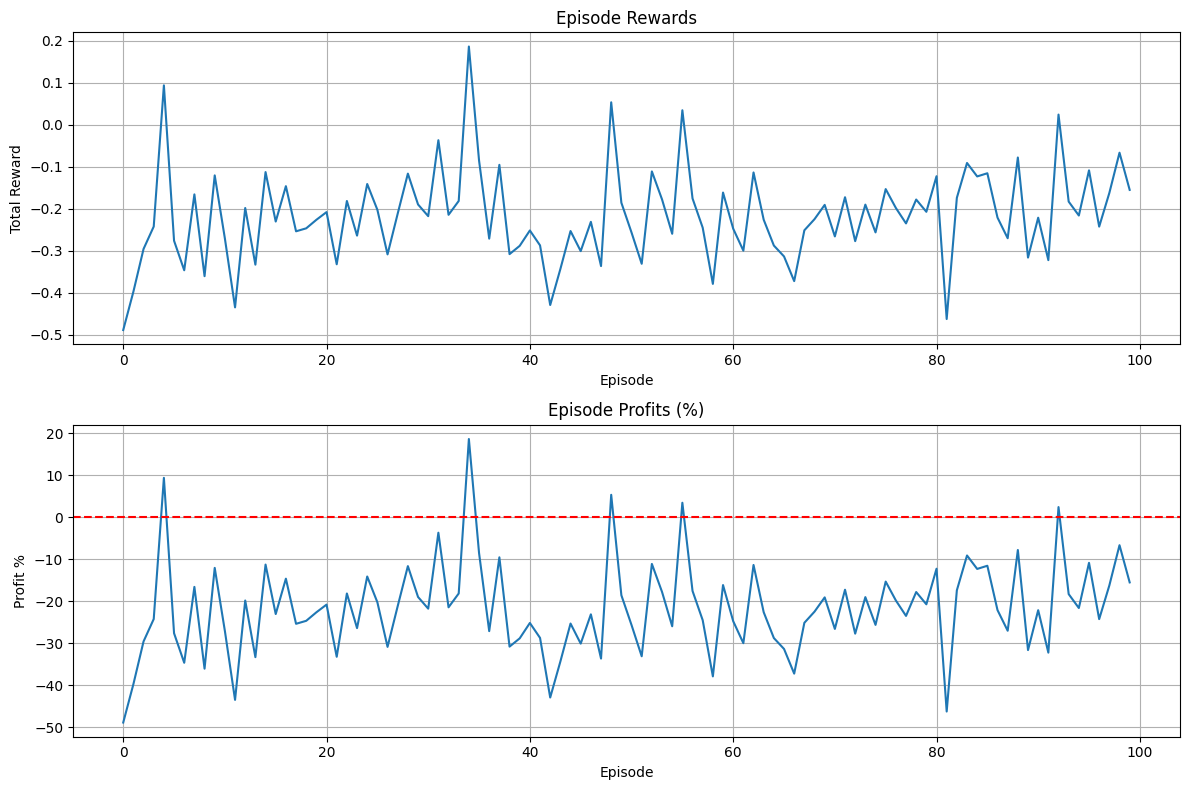

Running backtest on test data...

=== Backtest Results ===
Initial Balance: $10,000.00
Final Equity: $9,969.75
Total Return: -0.30%
Max Drawdown: 5.42%
Number of Trades: 72


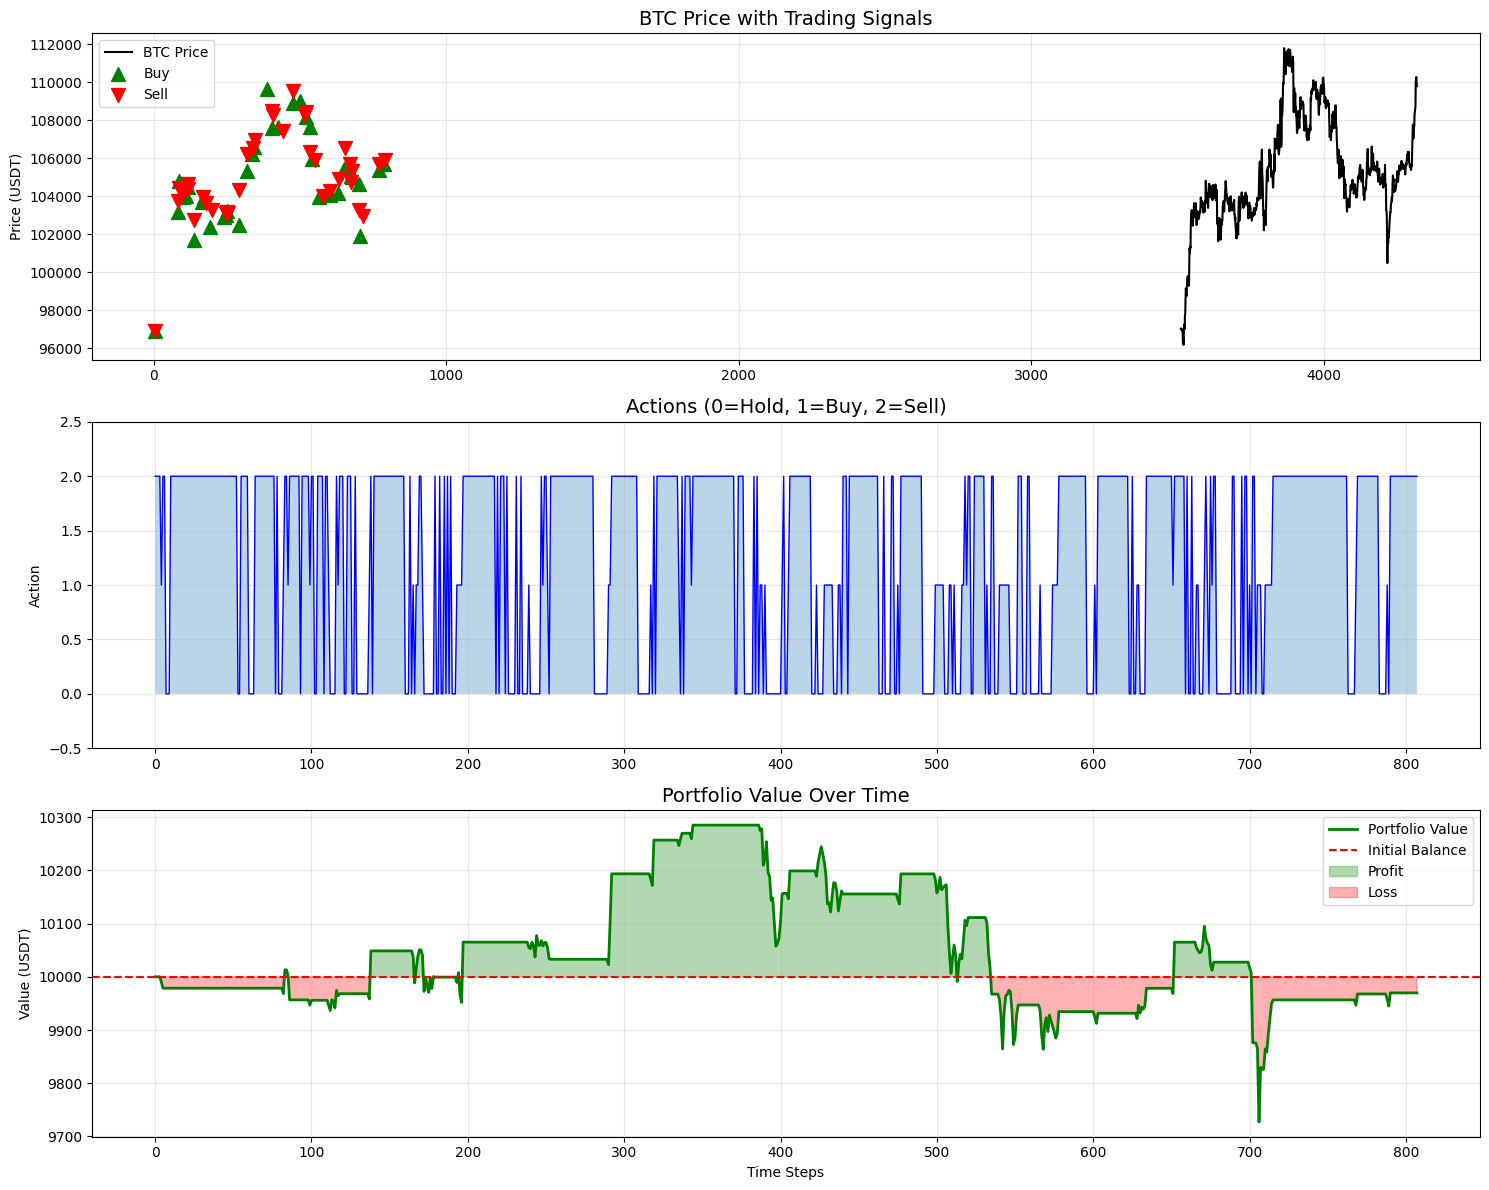


=== Buy & Hold Strategy ===
Initial Balance: $10,000.00
Start Price: $97,030.01
End Price: $109,659.68
Final Value: $11,301.63
Return: 13.02%

=== Strategy Comparison ===
DQN Agent Return: -0.30%
Buy & Hold Return: 13.02%
Outperformance: -13.32%
Model saved to dqn_btc_model.pth
Results saved to results.json

=== Training Complete! ===


In [ ]:
# %% [markdown]
# # CRYPPO - Cryptocurrency Futures Trading Bot with Deep Q-Learning
# Futures trading with Long/Short positions and liquidation

# %% [markdown]
# ## 1. Import Libraries & Setup

# %%
import ccxt
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple
import matplotlib.pyplot as plt
import random
from datetime import datetime
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Set random seeds
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# %% [markdown]
# ## 2. Download Bitcoin Data

# %%
def download_btc_data(symbol='BTC/USDT', timeframe='1h', days=365):
    """Download Bitcoin data from Binance"""
    exchange = ccxt.binance({
        'rateLimit': 1200,
        'enableRateLimit': True,
    })
    
    # Calculate timestamps
    end_time = exchange.milliseconds()
    start_time = end_time - (days * 24 * 60 * 60 * 1000)
    
    print(f"Downloading {symbol} {timeframe} data...")
    all_ohlcv = []
    
    while start_time < end_time:
        try:
            ohlcv = exchange.fetch_ohlcv(symbol, timeframe, start_time, 1500)
            if not ohlcv:
                break
            all_ohlcv.extend(ohlcv)
            start_time = ohlcv[-1][0] + 1
            print(f"Downloaded {len(all_ohlcv)} candles...", end='\r')
        except Exception as e:
            print(f"Error: {e}")
            break
    
    # Convert to DataFrame
    df = pd.DataFrame(all_ohlcv, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume'])
    df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
    df = df.drop_duplicates(subset=['timestamp']).reset_index(drop=True)
    
    print(f"\nDownloaded {len(df)} candles")
    return df

# Download data
data = download_btc_data(days=180)  # 6 months of hourly data
print(f"Data shape: {data.shape}")
print(f"Date range: {data['datetime'].min()} to {data['datetime'].max()}")

# %% [markdown]
# ## 3. Prepare Features

# %%
def add_features(df):
    """Add technical indicators as features"""
    df = df.copy()
    
    # Price features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['high_low_ratio'] = (df['high'] - df['low']) / df['close']  # Volatility indicator
    
    # Moving averages
    df['sma_10'] = df['close'].rolling(10).mean()
    df['sma_30'] = df['close'].rolling(30).mean()
    df['sma_ratio'] = df['sma_10'] / df['sma_30']
    
    # RSI
    delta = df['close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    rs = gain / loss
    df['rsi'] = 100 - (100 / (1 + rs))
    
    # Bollinger Bands
    df['bb_middle'] = df['close'].rolling(20).mean()
    bb_std = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_middle'] + (bb_std * 2)
    df['bb_lower'] = df['bb_middle'] - (bb_std * 2)
    df['bb_position'] = (df['close'] - df['bb_lower']) / (df['bb_upper'] - df['bb_lower'])
    
    # Volume
    df['volume_ratio'] = df['volume'] / df['volume'].rolling(20).mean()
    
    # Clean data
    df = df.dropna()
    
    return df

# Add features
data = add_features(data)
print(f"Data with features: {data.shape}")

# Select features for model
feature_columns = ['returns', 'log_returns', 'high_low_ratio', 'sma_ratio', 'rsi', 'bb_position', 'volume_ratio']
print(f"Selected features: {feature_columns}")

# %% [markdown]
# ## 4. Futures Trading Environment

# %%
class FuturesTradingEnv:
    """Futures trading environment with long/short positions and liquidation"""
    
    def __init__(self, data, initial_balance=10000, fee_rate=0.001, liquidation_threshold=0.05):
        self.data = data.reset_index(drop=True)
        self.initial_balance = initial_balance
        self.fee_rate = fee_rate
        self.liquidation_threshold = liquidation_threshold  # 5% loss = liquidation
        
        # Features for observation
        self.feature_columns = feature_columns
        
        # Actions: 0=HOLD, 1=LONG, 2=SHORT, 3=EXIT
        self.action_space = 4
        
        self.reset()
        
    def reset(self):
        self.current_step = 50  # Start after having enough history
        self.balance = self.initial_balance
        self.position = None  # None, 'long', or 'short'
        self.entry_price = 0
        self.position_size = 0  # Amount in USDT
        self.trades = []
        
        # History tracking
        self.balance_history = [self.balance]
        self.equity_history = [self.balance]
        self.action_history = []
        self.position_history = []
        
        return self._get_observation()
    
    def _get_observation(self):
        """Get current market state"""
        # Get features at current step
        features = self.data[self.feature_columns].iloc[self.current_step].values
        
        # Add position info
        current_price = self.data['close'].iloc[self.current_step]
        
        # Position encoding
        position_encoding = [0, 0]  # [is_long, is_short]
        unrealized_pnl_pct = 0
        
        if self.position == 'long':
            position_encoding[0] = 1
            unrealized_pnl_pct = (current_price - self.entry_price) / self.entry_price
        elif self.position == 'short':
            position_encoding[1] = 1
            unrealized_pnl_pct = (self.entry_price - current_price) / self.entry_price
        
        position_info = np.array([
            position_encoding[0],  # is_long
            position_encoding[1],  # is_short
            self.position_size / self.initial_balance,  # position size ratio
            unrealized_pnl_pct,  # unrealized P&L %
            self.balance / self.initial_balance,  # balance ratio
        ])
        
        return np.concatenate([features, position_info]).astype(np.float32)
    
    def _check_liquidation(self):
        """Check if position should be liquidated using high/low prices"""
        if self.position is None:
            return False
        
        # Get current candle high/low prices
        high_price = self.data['high'].iloc[self.current_step]
        low_price = self.data['low'].iloc[self.current_step]
        
        if self.position == 'long':
            # Long position: check if low price hits liquidation
            worst_price = low_price
            loss_pct = (worst_price - self.entry_price) / self.entry_price
            return loss_pct <= -self.liquidation_threshold
            
        else:  # short position
            # Short position: check if high price hits liquidation
            worst_price = high_price
            loss_pct = (self.entry_price - worst_price) / self.entry_price
            return loss_pct <= -self.liquidation_threshold
    
    def _execute_action(self, action):
        """Execute trading action"""
        current_price = self.data['close'].iloc[self.current_step]
        reward = 0
        
        # Check for liquidation FIRST (before any action)
        if self._check_liquidation():
            # Liquidation: lose entire position
            loss = -self.position_size  # Lose entire margin
            self.balance = 0  # Lost everything (in real futures, might keep some)
            
            self.trades.append({
                'step': self.current_step,
                'action': 'liquidation',
                'position': self.position,
                'entry_price': self.entry_price,
                'exit_price': current_price,
                'loss': loss
            })
            
            self.position = None
            self.entry_price = 0
            self.position_size = 0
            
            return -1.0  # Maximum penalty
        
        # Regular actions
        if action == 0:  # HOLD
            pass
            
        elif action == 1 and self.position is None:  # LONG
            # Open long position with available balance
            self.position_size = self.balance * (1 - self.fee_rate)
            self.balance = 0
            self.position = 'long'
            self.entry_price = current_price
            
            self.trades.append({
                'step': self.current_step,
                'action': 'open_long',
                'price': current_price,
                'size': self.position_size
            })
            
        elif action == 2 and self.position is None:  # SHORT
            # Open short position with available balance
            self.position_size = self.balance * (1 - self.fee_rate)
            self.balance = 0
            self.position = 'short'
            self.entry_price = current_price
            
            self.trades.append({
                'step': self.current_step,
                'action': 'open_short',
                'price': current_price,
                'size': self.position_size
            })
            
        elif action == 3 and self.position is not None:  # EXIT
            # Close position
            if self.position == 'long':
                pnl_pct = (current_price - self.entry_price) / self.entry_price
            else:  # short
                pnl_pct = (self.entry_price - current_price) / self.entry_price
            
            gross_pnl = self.position_size * pnl_pct
            exit_value = self.position_size + gross_pnl
            self.balance = exit_value * (1 - self.fee_rate)  # Deduct exit fee
            
            self.trades.append({
                'step': self.current_step,
                'action': f'close_{self.position}',
                'entry_price': self.entry_price,
                'exit_price': current_price,
                'pnl': gross_pnl,
                'pnl_pct': pnl_pct
            })
            
            # Calculate reward based on P&L
            reward = pnl_pct * 0.1  # Scale down for stability
            
            self.position = None
            self.entry_price = 0
            self.position_size = 0
        
        return reward
    
    def step(self, action):
        """Execute one trading step"""
        # Execute action and get immediate reward
        action_reward = self._execute_action(action)
        
        # Calculate total equity
        current_price = self.data['close'].iloc[self.current_step]
        if self.position == 'long':
            unrealized_pnl = self.position_size * ((current_price - self.entry_price) / self.entry_price)
            equity = self.balance + self.position_size + unrealized_pnl
        elif self.position == 'short':
            unrealized_pnl = self.position_size * ((self.entry_price - current_price) / self.entry_price)
            equity = self.balance + self.position_size + unrealized_pnl
        else:
            equity = self.balance
        
        # Calculate step reward (combination of action reward and holding reward)
        prev_equity = self.equity_history[-1] if self.equity_history else self.initial_balance
        equity_change = (equity - prev_equity) / self.initial_balance
        reward = action_reward + equity_change
        
        # Update history
        self.balance_history.append(self.balance)
        self.equity_history.append(equity)
        self.action_history.append(action)
        self.position_history.append(
            0 if self.position is None else (1 if self.position == 'long' else 2)
        )
        
        # Move to next step
        self.current_step += 1
        done = (self.current_step >= len(self.data) - 1) or (equity <= 0)
        
        next_obs = self._get_observation() if not done else np.zeros_like(self._get_observation())
        
        info = {
            'equity': equity,
            'price': current_price,
            'position': self.position,
            'balance': self.balance
        }
        
        return next_obs, reward, done, info
    
    def render(self):
        """Print current state"""
        current_price = self.data['close'].iloc[self.current_step]
        equity = self.equity_history[-1] if self.equity_history else self.initial_balance
        print(f"Step {self.current_step}: Price=${current_price:.2f}, "
              f"Position={self.position}, Equity=${equity:.2f}")

# Test environment
env = FuturesTradingEnv(data)
obs = env.reset()
print(f"Observation shape: {obs.shape}")
print(f"Action space: {env.action_space} actions")
print("Actions: 0=HOLD, 1=LONG, 2=SHORT, 3=EXIT")

# %% [markdown]
# ## 5. Deep Q-Network Model

# %%
class DQN(nn.Module):
    def __init__(self, input_size, hidden_size=128, output_size=4):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc4 = nn.Linear(hidden_size // 2, output_size)
        self.dropout = nn.Dropout(0.2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Experience replay
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'done'))

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, *args):
        self.buffer.append(Transition(*args))
    
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    
    def __len__(self):
        return len(self.buffer)

# %% [markdown]
# ## 6. DQN Agent

# %%
class DQNAgent:
    def __init__(self, state_size, action_size, lr=0.001):
        self.state_size = state_size
        self.action_size = action_size
        
        # Neural networks
        self.q_network = DQN(state_size, output_size=action_size).to(device)
        self.target_network = DQN(state_size, output_size=action_size).to(device)
        self.target_network.load_state_dict(self.q_network.state_dict())
        
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        self.memory = ReplayBuffer(10000)
        
        # Parameters
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.batch_size = 32
        
    def act(self, state, env=None, training=True):
        """Choose action using epsilon-greedy policy with valid action masking"""
        # Valid action masking
        valid_actions = [0]  # HOLD is always valid
        
        if env:
            if env.position is None:
                valid_actions.extend([1, 2])  # Can open LONG or SHORT
            else:
                valid_actions.append(3)  # Can EXIT existing position
        else:
            valid_actions = list(range(self.action_size))
        
        if training and random.random() < self.epsilon:
            return random.choice(valid_actions)
        
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        self.q_network.eval()
        with torch.no_grad():
            q_values = self.q_network(state_tensor).cpu().numpy()[0]
        self.q_network.train()
        
        # Mask invalid actions
        masked_q_values = np.full(self.action_size, -np.inf)
        for action in valid_actions:
            masked_q_values[action] = q_values[action]
        
        return np.argmax(masked_q_values)
    
    def remember(self, state, action, next_state, reward, done):
        self.memory.push(state, action, next_state, reward, done)
    
    def replay(self):
        """Train the model on a batch of experiences"""
        if len(self.memory) < self.batch_size:
            return
        
        transitions = self.memory.sample(self.batch_size)
        batch = Transition(*zip(*transitions))
        
        # Convert to tensors
        state_batch = torch.FloatTensor(batch.state).to(device)
        action_batch = torch.LongTensor(batch.action).to(device)
        reward_batch = torch.FloatTensor(batch.reward).to(device)
        next_state_batch = torch.FloatTensor(batch.next_state).to(device)
        done_batch = torch.FloatTensor(batch.done).to(device)
        
        # Current Q values
        current_q_values = self.q_network(state_batch).gather(1, action_batch.unsqueeze(1))
        
        # Next Q values
        next_q_values = self.target_network(next_state_batch).max(1)[0].detach()
        target_q_values = reward_batch + (self.gamma * next_q_values * (1 - done_batch))
        
        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)
        
        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Decay epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_target_network(self):
        self.target_network.load_state_dict(self.q_network.state_dict())

# %% [markdown]
# ## 7. Training the Agent

# %%
# Split data
train_size = int(0.8 * len(data))
train_data = data[:train_size].copy()
test_data = data[train_size:].copy()

print(f"Train data: {len(train_data)} samples")
print(f"Test data: {len(test_data)} samples")

# Create agent
state_size = len(feature_columns) + 5  # features + position info
action_size = 4  # HOLD, LONG, SHORT, EXIT
agent = DQNAgent(state_size, action_size)

# Training
episodes = 100
train_env = FuturesTradingEnv(train_data)

episode_rewards = []
episode_profits = []
episode_trades = []

print("Training DQN Agent for Futures Trading...")
for episode in range(episodes):
    state = train_env.reset()
    total_reward = 0
    
    while True:
        action = agent.act(state, train_env, training=True)
        next_state, reward, done, info = train_env.step(action)
        agent.remember(state, action, next_state, reward, done)
        state = next_state
        total_reward += reward
        
        if len(agent.memory) > agent.batch_size:
            agent.replay()
        
        if done:
            break
    
    # Update target network
    if episode % 10 == 0:
        agent.update_target_network()
    
    # Calculate metrics
    final_equity = info['equity']
    profit = (final_equity / train_env.initial_balance - 1) * 100
    num_trades = len(train_env.trades)
    
    episode_rewards.append(total_reward)
    episode_profits.append(profit)
    episode_trades.append(num_trades)
    
    if episode % 10 == 0:
        print(f"Episode {episode}: Reward: {total_reward:.4f}, "
              f"Profit: {profit:.2f}%, Trades: {num_trades}, "
              f"Epsilon: {agent.epsilon:.3f}")

print("Training completed!")

# %% [markdown]
# ## 8. Plot Training Progress

# %%
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Episode rewards
ax1.plot(episode_rewards)
ax1.set_title('Episode Rewards')
ax1.set_xlabel('Episode')
ax1.set_ylabel('Total Reward')
ax1.grid(True)

# Episode profits
ax2.plot(episode_profits)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_title('Episode Profits (%)')
ax2.set_xlabel('Episode')
ax2.set_ylabel('Profit %')
ax2.grid(True)

# Number of trades
ax3.plot(episode_trades)
ax3.set_title('Number of Trades per Episode')
ax3.set_xlabel('Episode')
ax3.set_ylabel('# Trades')
ax3.grid(True)

# Moving average profit
window = 20
if len(episode_profits) >= window:
    ma_profits = pd.Series(episode_profits).rolling(window).mean()
    ax4.plot(episode_profits, alpha=0.3, label='Episode Profit')
    ax4.plot(ma_profits, label=f'{window}-Episode MA', linewidth=2)
    ax4.axhline(y=0, color='r', linestyle='--')
    ax4.set_title('Smoothed Profits')
    ax4.set_xlabel('Episode')
    ax4.set_ylabel('Profit %')
    ax4.legend()
    ax4.grid(True)

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 9. Backtesting on Test Data

# %%
def backtest_futures(agent, data, plot=True):
    """Run backtest and plot results with high/low liquidation check"""
    env = FuturesTradingEnv(data)
    state = env.reset()
    
    actions = []
    prices = []
    highs = []
    lows = []
    equities = []
    positions = []
    
    # Disable exploration
    original_epsilon = agent.epsilon
    agent.epsilon = 0
    
    while True:
        action = agent.act(state, env, training=False)
        state, reward, done, info = env.step(action)
        
        actions.append(action)
        step_idx = env.current_step - 1
        prices.append(data['close'].iloc[step_idx])
        highs.append(data['high'].iloc[step_idx])
        lows.append(data['low'].iloc[step_idx])
        equities.append(info['equity'])
        positions.append(env.position_history[-1])
        
        if done:
            break
    
    agent.epsilon = original_epsilon
    
    # Calculate metrics
    final_return = (equities[-1] / env.initial_balance - 1) * 100
    max_eq = max(equities) if equities else env.initial_balance
    max_drawdown = (max_eq - min(equities)) / max_eq * 100 if max_eq > 0 else 0
    
    # Trade analysis
    total_trades = len([t for t in env.trades if t['action'] in ['open_long', 'open_short']])
    winning_trades = len([t for t in env.trades if t.get('pnl', 0) > 0])
    liquidations = len([t for t in env.trades if t['action'] == 'liquidation'])
    
    print(f"\n=== Futures Backtest Results ===")
    print(f"Initial Balance: ${env.initial_balance:,.2f}")
    print(f"Final Equity: ${equities[-1]:,.2f}")
    print(f"Total Return: {final_return:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    print(f"Total Trades: {total_trades}")
    print(f"Winning Trades: {winning_trades}")
    print(f"Liquidations: {liquidations}")
    
    if plot:
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12))
        
        # 1. Price chart with positions and high/low
        x = range(len(prices))
        
        # Plot candlestick-style high/low bars
        for i in x:
            ax1.plot([i, i], [lows[i], highs[i]], color='gray', alpha=0.3, linewidth=1)
        
        # Plot close price
        ax1.plot(x, prices, label='Close Price', color='black', linewidth=1.5)
        
        # Color background by position
        for i in range(1, len(positions)):
            if positions[i] == 1:  # Long
                ax1.axvspan(i-1, i, alpha=0.2, color='green')
            elif positions[i] == 2:  # Short
                ax1.axvspan(i-1, i, alpha=0.2, color='red')
        
        # Mark trade points
        for trade in env.trades:
            idx = trade['step'] - env.reset().shape[0] + 50
            if 0 <= idx < len(prices):
                if trade['action'] == 'open_long':
                    ax1.scatter(idx, trade['price'], marker='^', color='green', s=100, zorder=5)
                elif trade['action'] == 'open_short':
                    ax1.scatter(idx, trade['price'], marker='v', color='red', s=100, zorder=5)
                elif trade['action'] in ['close_long', 'close_short']:
                    ax1.scatter(idx, trade['exit_price'], marker='x', color='blue', s=100, zorder=5)
                elif trade['action'] == 'liquidation':
                    ax1.scatter(idx, prices[idx], marker='o', color='black', s=200, zorder=5)
        
        ax1.set_title('BTC Price with Futures Positions (Green=Long, Red=Short)', fontsize=14)
        ax1.set_ylabel('Price (USDT)')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        
        # 2. Actions
        ax2.plot(actions, color='blue', linewidth=1)
        ax2.fill_between(range(len(actions)), actions, alpha=0.3)
        ax2.set_title('Actions (0=HOLD, 1=LONG, 2=SHORT, 3=EXIT)', fontsize=14)
        ax2.set_ylabel('Action')
        ax2.set_ylim(-0.5, 3.5)
        ax2.grid(True, alpha=0.3)
        
        # 3. Portfolio equity
        ax3.plot(equities, label='Portfolio Equity', color='green', linewidth=2)
        ax3.axhline(y=env.initial_balance, color='red', linestyle='--', label='Initial Balance')
        ax3.fill_between(range(len(equities)), equities, env.initial_balance, 
                        where=[e >= env.initial_balance for e in equities], 
                        color='green', alpha=0.3, label='Profit')
        ax3.fill_between(range(len(equities)), equities, env.initial_balance, 
                        where=[e < env.initial_balance for e in equities], 
                        color='red', alpha=0.3, label='Loss')
        
        # Mark liquidation points
        for trade in env.trades:
            if trade['action'] == 'liquidation':
                idx = trade['step'] - env.reset().shape[0] + 50
                if 0 <= idx < len(equities):
                    ax3.axvline(x=idx, color='black', linestyle=':', alpha=0.7)
                    ax3.text(idx, equities[idx], 'LIQ', ha='center', va='bottom')
        
        ax3.set_title('Portfolio Equity Over Time', fontsize=14)
        ax3.set_xlabel('Time Steps')
        ax3.set_ylabel('Equity (USDT)')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return {
        'final_return': final_return,
        'max_drawdown': max_drawdown,
        'total_trades': total_trades,
        'winning_trades': winning_trades,
        'liquidations': liquidations,
        'trades': env.trades,
        'equities': equities
    }

# Run backtest
print("Running futures backtest on test data...")
test_results = backtest_futures(agent, test_data, plot=True)

# %% [markdown]
# ## 10. Compare with Buy & Hold Strategy

# %%
def buy_and_hold_strategy(data, initial_balance=10000):
    """Simple buy and hold strategy for comparison"""
    start_price = data['close'].iloc[50]
    end_price = data['close'].iloc[-1]
    
    # Check worst drawdown using low prices
    position_value = [(initial_balance / start_price) * price for price in data['close'].iloc[50:]]
    max_value = max(position_value)
    min_value = min(position_value)
    max_drawdown = (max_value - min_value) / max_value * 100
    
    final_value = (initial_balance / start_price) * end_price
    return_pct = (final_value / initial_balance - 1) * 100
    
    print(f"\n=== Buy & Hold Strategy ===")
    print(f"Initial Balance: ${initial_balance:,.2f}")
    print(f"Start Price: ${start_price:,.2f}")
    print(f"End Price: ${end_price:,.2f}")
    print(f"Final Value: ${final_value:,.2f}")
    print(f"Return: {return_pct:.2f}%")
    print(f"Max Drawdown: {max_drawdown:.2f}%")
    
    return return_pct, max_drawdown

# Compare strategies
bh_return, bh_drawdown = buy_and_hold_strategy(test_data)

print(f"\n=== Strategy Comparison ===")
print(f"Futures DQN Return: {test_results['final_return']:.2f}%")
print(f"Buy & Hold Return: {bh_return:.2f}%")
print(f"Outperformance: {test_results['final_return'] - bh_return:.2f}%")
print(f"\nFutures DQN Max Drawdown: {test_results['max_drawdown']:.2f}%")
print(f"Buy & Hold Max Drawdown: {bh_drawdown:.2f}%")
print(f"Drawdown Improvement: {bh_drawdown - test_results['max_drawdown']:.2f}%")

# %% [markdown]
# ## 11. Save Model and Results

# %%
# Save the trained model
model_path = Path('futures_dqn_model.pth')
torch.save({
    'model_state_dict': agent.q_network.state_dict(),
    'optimizer_state_dict': agent.optimizer.state_dict(),
    'epsilon': agent.epsilon,
}, model_path)

print(f"Model saved to {model_path}")

# Save results
results = {
    'test_return': test_results['final_return'],
    'test_max_drawdown': test_results['max_drawdown'],
    'test_trades': test_results['total_trades'],
    'test_winning_trades': test_results['winning_trades'],
    'test_liquidations': test_results['liquidations'],
    'buy_hold_return': bh_return,
    'buy_hold_drawdown': bh_drawdown,
    'outperformance': test_results['final_return'] - bh_return,
    'final_epsilon': agent.epsilon,
    'timestamp': datetime.now().isoformat()
}

with open('futures_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("Results saved to futures_results.json")
print("\n=== Futures Trading Bot Training Complete! ===")